<a href="https://colab.research.google.com/github/DougJ/Thinkful-Capstone-Projects/blob/master/DL_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ResNet50 Architecture on Covid X-Ray transfer learning from Pnumothorax X-Ray and imagenet.

* Authored by Doug Johnson  

Goal:   
Classify X-Ray for Covid vs Not Covid.  

Problem Statement:  
Test if transfer learning can overcome small number of target class images.  

## Summary

1. Created tensors.  

2. Use imagenet weights and apply transfer learning to NIH dataset (Pnumothorax) then export best weights.  

3. Load best weights from imagenet / NIH(Pnumothorax) and then run on Covid X-ray.  

4. Use learning rate reduction and callbacks.

## Import Modules

In [0]:
import sys
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import backend as K
from keras.models import Sequential, Model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.optimizers import SGD, Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# LOAD DATASET
from os import listdir
import numpy as np
from numpy import asarray, save
import pandas as pd

from sklearn.model_selection import train_test_split

# PLOT IMAGES 
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

# METRICS AND REPORTING
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

## Global Variable Designation

In [0]:
VERSION_IN        = 'V1-2_Adam' # Adam is optimizer 
VERSION_OUT       = 'V2-2'

BASE_PATH         = '/content/drive/My Drive/'
DATASET_PATH      = 'images/Preprocessed_Tensors/COVID_IMG_preprocessed_balanced/'
OUTPUT_PATH       = 'images/COVID_19_project/pretrained_weights/'
FOLDER_PATH_TRAIN = BASE_PATH + DATASET_PATH
FOLDER_PATH_TEST  = BASE_PATH + DATASET_PATH

WEIGHTS_IN        = BASE_PATH + 'ResNet50_weights_best_' + VERSION_IN  + '.hdf5' 
WEIGHTS_OUT       = BASE_PATH + 'ResNet50_weights_' + VERSION_OUT + '.hdf5'
WEIGHTS_MODEL_IN  = BASE_PATH + 'ResNet50_model_' + VERSION_IN  + '.h5' 
WEIGHTS_MODEL_OUT = BASE_PATH + 'ResNet50_model_' + VERSION_OUT + '.h5' # IDEALLY INPUT RESNET AND MODEL/OUTPUT FILE CALLED

IMAGE_SIZE        = 224   
INPUT_LAYERS      = 3     # RED, GREEN, BLUE = 3; IF 3 REMOVE FROM ImageDataGenerator
LAYERS_TRANS      = 3     # GREYSCALE = 1; FOR MEMORY AND RUNTIME EFFICIENCY CONVERT TO GREYSCALE, !!! DO SOME REQUIRE 1 VS 3?
NUM_CLASSES       = 2     # NUMBER OF TARGET CLASSES, BINARY - TRUE OR FALSE = 2,CAT OR DOG OR CHICKEN = 3 ...
BATCH_SIZE_N      = 16    # MEMORY MANAGEMENT, INCREASE IF HAVE LOT OF MEMORY
FREEZE_LAYERS     = 2     # !!! READ UP ON SIGNIFICANCE
NUM_EPOCHS        = 50  
VERBOSE_EPOCH     = 1     # EPOCH OUTPUT 0 = NO OUTPUT, 1 = OUTPUT

## Access Data

In [0]:
# MOUNT GOOGLE DRIVE TO ACCESS SHARED IMAGES FOLDER
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ls /content/drive/My\ Drive/images/Preprocessed_Tensors/COVID_IMG_preprocessed_balanced/

X_test.npy  X_train.npy  X_val.npy  y_test.npy  y_train.npy  y_val.npy


In [0]:
# TENSORS 
X_train = np.load(FOLDER_PATH_TRAIN + 'X_train.npy')
X_test  = np.load(FOLDER_PATH_TEST  + 'X_test.npy')
y_train = np.load(FOLDER_PATH_TRAIN + 'y_train.npy')
y_test  = np.load(FOLDER_PATH_TEST  + 'y_test.npy')

In [0]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

3424
3424
1472
1472


## Define Model Architecture

In [0]:
def define_model_resnet50():
    '''
    ResNet50 architecture setup. 
    Initialize with imagenet weight file for transfer learning.
    '''
    net = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(IMAGE_SIZE, IMAGE_SIZE, INPUT_LAYERS))
    x = net.output
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
    net_final = Model(inputs=net.input, outputs=output_layer)
    for layer in net_final.layers[:FREEZE_LAYERS]:
        layer.trainable = False
    for layer in net_final.layers[FREEZE_LAYERS:]:
        layer.trainable = True
    net_final.compile(optimizer=keras.optimizers.Adadelta(), 
                      loss='categorical_crossentropy', metrics=['accuracy'])
    return net_final

## Define Learning Rate and Callback Checkpoint

In [0]:
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# IMPLEMENT LEARNING RATE REDUCTION BASED ON VALIDATION LOSS
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss', #monitor val_loss
    factor=0.2, 
    patience=4, #If model does not improve by epsilon in 4 epochs, then reduce lr by factor.  
    min_delta=0.0001, 
    cooldown = 3, # wait 3 epochs before starting again
    min_lr=10e-5,
    verbose=1)

# SAVE WEIGHT FILE FROM BEST RUN, HAVE VERBOSE OUTPUT BASED ON VALIDATION ACCURACY
checkpoint = keras.callbacks.callbacks.ModelCheckpoint(
    WEIGHTS_OUT, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

## Plot Diagnostic Learning Curves

In [0]:
def summarize_diagnostics(history):
    '''
    Plot entropy chart
    Plot accuracy chart
    '''
    
    plt.figure(figsize=(8,10))

    # PLOT LOSS
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    
    # PLOT ACCURACY
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.show()
    plt.close()

## Define Test Harness

In [0]:
def run_test_harness():
    '''
    Test harness calls model definition function 
    Resizes images
    Creates more images with Image Data Generator: rotate, shift, shear, zoom, flip, ...
    Fits the data
    Gives performance summary
    Calls the learning curve graph
    '''
    
    model = define_model_resnet50()
    model.load_weights(WEIGHTS_IN)
    
    # CREATE DATA ITERATORS
    train_datagen = ImageDataGenerator(rotation_range=15, 
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range= 0.2,
                                      zoom_range=0.2,
                                      horizontal_flip = True)

    # WORK WITH TENSORS
    train_batches = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE_N)
    test_batches = train_datagen.flow(X_test, y_test, batch_size = BATCH_SIZE_N)

    print("train batches {}".format(len(train_batches)))
    print("test  batches {}".format(len(test_batches)))
    print("\n")

    # FIT MODEL
    history = model.fit_generator(train_batches, 
                                  steps_per_epoch=len(train_batches),
                                  callbacks=[lr_reduce,checkpoint],
                                  validation_data=test_batches, 
                                  validation_steps=len(test_batches), 
                                  verbose=VERBOSE_EPOCH,
                                  epochs=NUM_EPOCHS)

    # SAVE TRAINED WEIGHTS
    model.save(WEIGHTS_MODEL_OUT)

    # EVALUATE MODEL
    _, acc = model.evaluate_generator(test_batches, 
                                      steps=len(test_batches), 
                                      verbose=0)
    
    print("\nAccuracy > {:.3f}".format(acc * 100.0))

    # LEARNING CURVES
    summarize_diagnostics(history)

## Run Test Harness

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


train batches 214
test  batches 92


Epoch 1/50
214/214 [==============================] - 73s 341ms/step - loss: 0.5496 - accuracy: 0.7138 - val_loss: 0.6344 - val_accuracy: 0.5496

Epoch 00001: val_accuracy improved from -inf to 0.54959, saving model to /content/drive/My Drive/ResNet50_weights_V2-2.hdf5
Epoch 2/50
214/214 [==============================] - 57s 266ms/step - loss: 0.3987 - accuracy: 0.8221 - val_loss: 4.1783 - val_accuracy: 0.5503

Epoch 00002: val_accuracy improved from 0.54959 to 0.55027, saving model to /content/drive/My Drive/ResNet50_weights_V2-2.hdf5
Epoch 3/50
214/214 [==============================] - 57s 266ms/step - loss: 0.3518 - accuracy: 0.8478 - val_loss: 1.0894 - val_accuracy: 0.5265

Epoch 00003: val_accuracy did not improve from 0.55027
Epoch 4/50
214/214 [==============================] - 57s 264ms/step - loss: 0.3342 - accuracy: 0.8548 - val_loss: 0.5660 - val_accuracy: 0.7643

Epoch 00004: val_accuracy improved from 0.55027 to 0.76427, saving model 

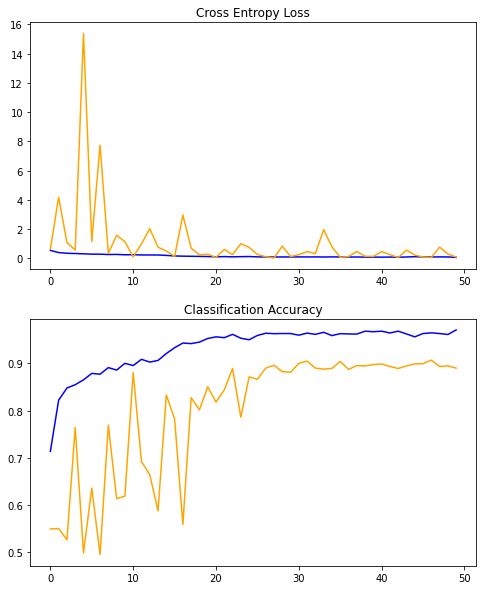

In [0]:
run_test_harness()

Conclusion:  
The overall process appears to add value to classification of Covid and Not Covid. 

Weaknesses:
Several images have text and arrow on them introducing non human X-Ray patterns which could allow for identification of Covid vs Not Covid on patterns that are not related to lungs. 